In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

import statsmodels.api as sm

# Display preferences.
%matplotlib inline
sns.set()
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

### Functions

In [2]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

### First, load the dataset from the weatherinszeged table from Thinkful's database.

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

wx_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

wx_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


### Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

In [4]:
wx_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


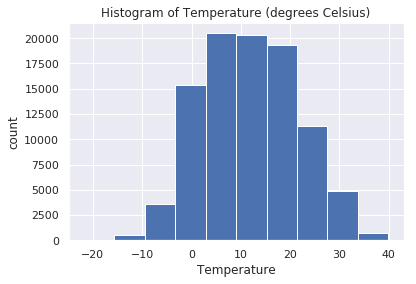

In [81]:
quick_histogram(wx_df['temperature'],xlabel="Temperature",title="Histogram of Temperature (degrees Celsius)")

In [31]:
wx_featureset = ['humidity','windspeed','windbearing','pressure']

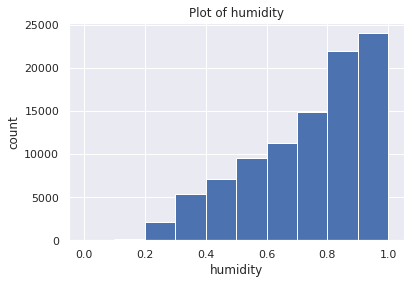

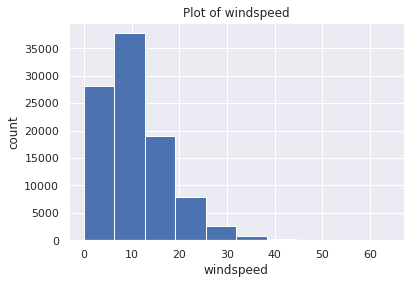

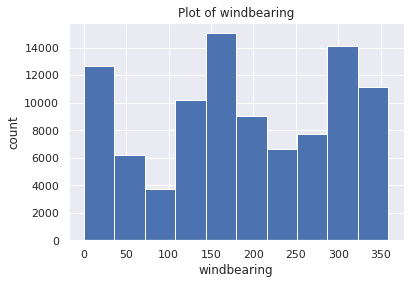

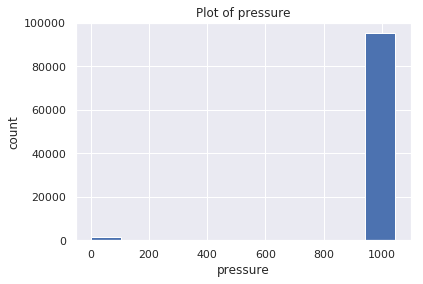

In [82]:
for attribute in wx_featureset:
    quick_histogram(wx_df[attribute],title="Plot of {}".format(attribute),xlabel=attribute)

In [70]:
# I see what look like outliers for atmospheric pressure, which should be reasonably close to 1000 mbar.
wx_df.loc[wx_df['pressure'] < 970,'pressure'].value_counts()

0.000    1288
Name: pressure, dtype: int64

There are 1288 zeroes for pressure. Since we are talking about a location in Hungary and not the vacuum of space, it's likely the zeroes represent missing data. I'm going to run through the exercise for now but may revisit this.

In [29]:
wx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [71]:
# Y is the target variable.
# I learned elsewhere that I need to reshape this feature so it is a 2-dimensional matrix.
Y = wx_df['temperature'].values.reshape(-1,1)

# X is the feature set.
X = wx_df[wx_featureset]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [83]:
lrm.score(X,Y)

0.4205778630374367

In [72]:
# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]]

Intercept: 
 [37.92643819]


In [46]:
X.shape

(96453, 5)

In [49]:
Y.shape

(96453, 1)

### Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

### Assumption one: linearity of the model in its coefficients

In [50]:
# Predictions of the linear regression
predictions = lrm.predict(X)
predictions

array([[ 6.47479331],
       [ 7.4525369 ],
       [ 8.3366275 ],
       ...,
       [17.33793889],
       [15.68609968],
       [16.37506898]])

In [52]:
predictions.shape

(96453, 1)

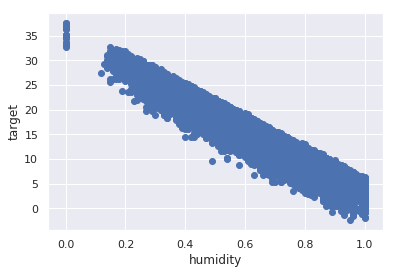

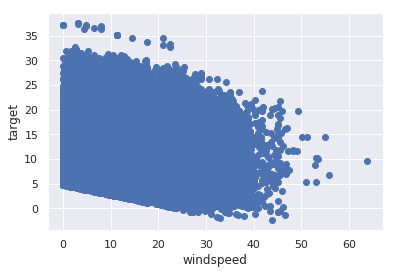

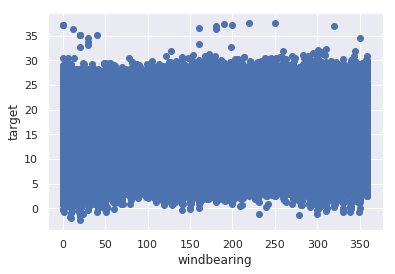

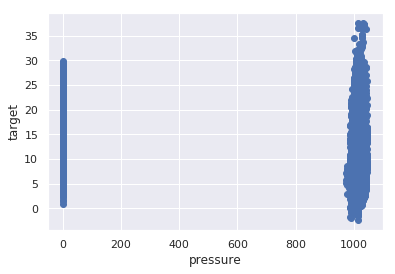

In [85]:
# We plot the estimated Y, and X features
for xfeature in wx_featureset:
    plt.scatter(X[xfeature], predictions)
    plt.xlabel(xfeature)
    plt.ylabel("target")
    plt.title('')
    plt.show()

These all seem to be linear relationships, so I think we're good here.

### Assumption two: the error term should be zero on average

As mentioned in the lesson, this problem is resolved by including a constant, which we've done here:

`const	37.9264`

In [54]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Wed, 24 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:08:01   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Assumption three: homoscedasticity

We can check for this using the Bartlett and Levene tests we learned about in the lesson.

I have learned that these tests require arrays and not matrices, so I am creating flattened copies of the errors and predictions matrices from above.

In [57]:
errors = Y - predictions
errors.shape

(96453, 1)

In [60]:
flat_errors = np.ndarray.flatten(errors)
flat_errors

array([2.99742891, 1.90301865, 1.04115028, ..., 4.70095   , 5.83612254,
       4.06381991])

In [61]:
flat_predictions = np.ndarray.flatten(predictions)
flat_predictions

array([ 6.47479331,  7.4525369 ,  8.3366275 , ..., 17.33793889,
       15.68609968, 16.37506898])

In [62]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


__The p-values of both tests are lower than 0.05--the test results reject the null hypothesis of these tests, which means our errors are heteroscedastic.__

If the variance of the output changes with different input values, then the model is not a reliable predictor--for some range of values, it may be great, but outside of that range it cannot be used.

If there are more useful, non-redundant variables to include, that may help.

I also noted earlier that there were around 1288 zero values in the atmospheric pressure column of the dataframe--and pressure should be reasonable close to 1000 mbar. Dealing with these outliers may help.

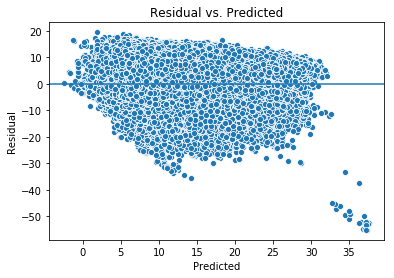

In [79]:
sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

I think this plot is showing us that for higher predicted values (starting around 33 degrees Celsius), there is lower variance in the error.

### Assumption four: low multicollinearity

We can visually check that the independent variables are not correlated with a heatmap.

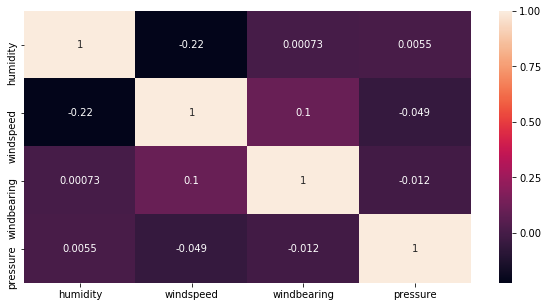

In [45]:
wx_corr = wx_df[wx_featureset].corr()

# We can check out a heatmap to see the correlations between our variables
plt.figure(figsize=(10,5))
sns.heatmap(wx_corr, annot=True)

This looks good--our chosen variables seem reasonably independent of each other.

For a larger set of features, we can run the corr() function and look at the column for the variables in question, maybe filtering for values that show significant correlation.

### Assumption five: error terms should be uncorrelated with one another

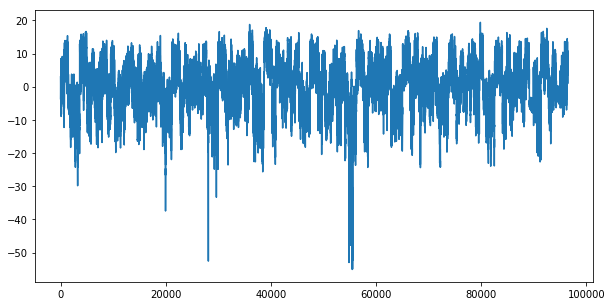

In [65]:
fig=plt.figure(figsize=(10,5))
plt.plot(errors)
plt.show()

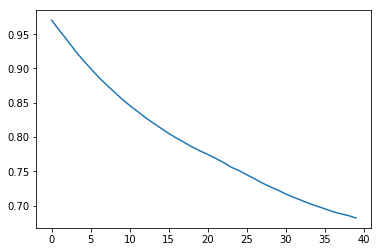

In [66]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

I...think this is okay? The plot of the autocorrelation function is almost linear though.

Correlation in the error terms may mean a relevant variable is missing from the model. Introducing that missing variable may help.

### Assumption six: features shouldn't be correlated with the errors (exogeneity)

In [67]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

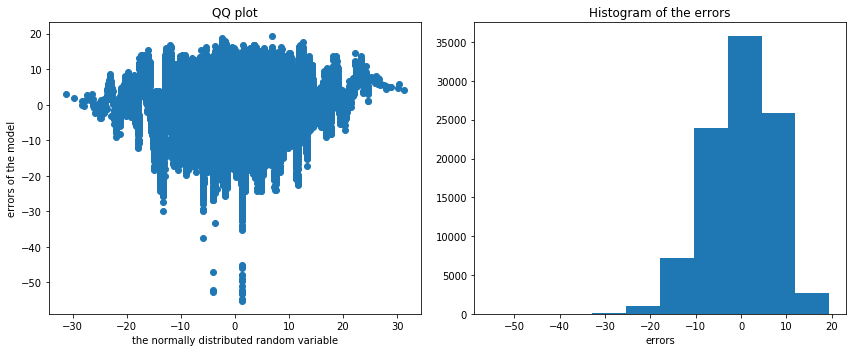

In [69]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

For sure the histogram shows us the errors are nearly, but not quite, normal. 

I don't understand QQ plots or what this is showing us really.

In [68]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252357 and p value is 0.0
Normality test statistics is [3375.4323077] and p value is [0.]


Missing variables could be a cause of problems with this assumption.